# Isolation Forest outlier detection on KDD Cup '99 dataset

## Method

[Isolation forests](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf) (IF) are tree based models specifically used for outlier detection. The IF isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of random trees, is a measure of normality and is used to define an anomaly score. Outliers can typically be isolated quicker, leading to shorter paths.

## Dataset

The outlier detector needs to detect computer network intrusions using TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN. A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack.

There are 4 types of attacks in the dataset:

- DOS: denial-of-service, e.g. syn flood;
- R2L: unauthorized access from a remote machine, e.g. guessing password;
- U2R: unauthorized access to local superuser (root) privileges;
- probing: surveillance and other probing, e.g., port scanning.

The dataset contains about 5 million connection records.

There are 3 types of features:

- basic features of individual connections, e.g. duration of connection
- content features within a connection, e.g. number of failed log in attempts
- traffic features within a 2 second window, e.g. number of connections to the same host as the current connection

This notebook requires the `seaborn` package for visualization which can be installed via `pip`:

In [ ]:
!pip install seaborn

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

from alibi_detect.od import IForest
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

## Load dataset

We only keep a number of continuous (18 out of 41) features.

In [2]:
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset
print(kddcup.data.shape, kddcup.target.shape)

(494021, 18) (494021,)


Assume that a model is trained on *normal* instances of the dataset (not outliers) and standardization is applied:

In [3]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=400000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float'), normal_batch.target
print(X_train.shape, y_train.shape)
print('{}% outliers'.format(100 * y_train.mean()))

(400000, 18) (400000,)
0.0% outliers


In [4]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)

Apply standardization:

In [5]:
X_train = (X_train - mean) / stdev

## Define outlier detector

We train an outlier detector from scratch:

In [6]:
filepath = 'my_path'  # change to directory where model is saved
detector_name = 'IForest'
filepath = os.path.join(filepath, detector_name)

# initialize outlier detector
od = IForest(threshold=None,  # threshold for outlier score
             n_estimators=100)

# train
od.fit(X_train)

# save the trained outlier detector
save_detector(od, filepath)

No threshold level set. Need to infer threshold using `infer_threshold`.


The warning tells us we still need to set the outlier threshold. This can be done with the `infer_threshold` method. We need to pass a batch of instances and specify what percentage of those we consider to be normal via `threshold_perc`. Let's assume we have some data which we know contains around 5% outliers. The percentage of outliers can be set with `perc_outlier` in the `create_outlier_batch` function.

In [7]:
np.random.seed(0)
perc_outlier = 5
threshold_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


In [8]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 0.0797010793476482


Let's save the outlier detector with updated threshold:

In [9]:
save_detector(od, filepath)

## Detect outliers

We now generate a batch of data with 10% outliers and detect the outliers in the batch. 

In [10]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 18) (1000,)
10.0% outliers


Predict outliers:

In [11]:
od_preds = od.predict(X_outlier, return_instance_score=True)

## Display results

F1 score and confusion matrix:

F1 score: 0.3279


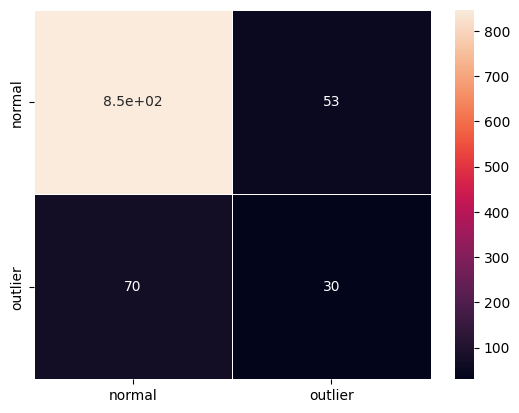

In [12]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {:.4f}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

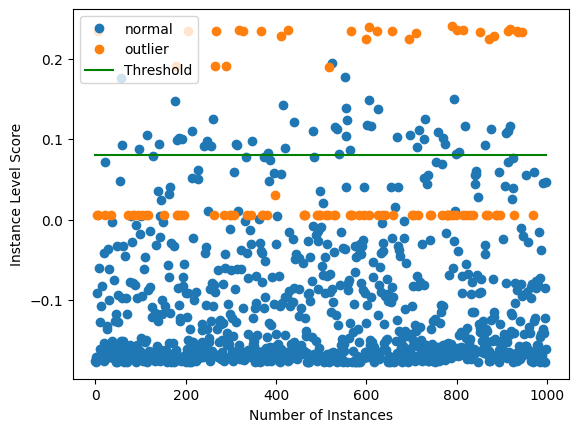

In [13]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

We can see that the isolation forest does not do a good job at detecting 1 type of outliers with an outlier score around 0. This makes inferring a good threshold without explicit knowledge about the outliers hard. Setting the threshold just below 0 would lead to significantly better detector performance for the outliers in the dataset. This is also reflected by the ROC curve:

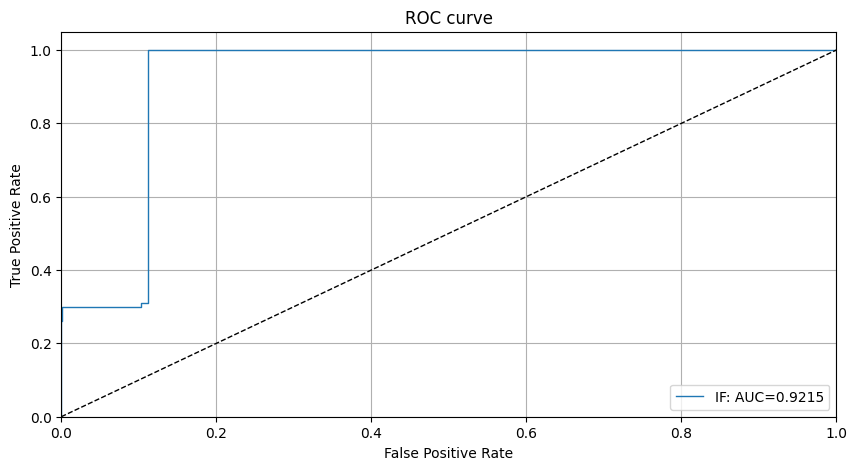

In [14]:
roc_data = {'IF': {'scores': od_preds['data']['instance_score'], 'labels': y_outlier}}
plot_roc(roc_data)